In [1]:
# import libraries
import json
import math
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from keras.applications import EfficientNetV2S
from keras.callbacks import Callback, ModelCheckpoint
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# To have reproducible results and compare them
nr_seed = 2019
import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
tf.random.set_seed(nr_seed)

In [2]:
# Image size
im_size = 224
# Batch size
BATCH_SIZE = 32

100%|████████████████████████████████████████| 448M/448M [00:00<00:00, 828MiB/s]
🍬  下载完成，正在解压...
🏁  数据集已经成功添加


In [2]:
!featurize dataset download f2bc5846-58a2-4a82-87e9-75ed3ebac00d

100%|██████████████████████████████████████| 13.4G/13.4G [00:43<00:00, 311MiB/s]
🍬  下载完成，正在解压...
🏁  数据集已经成功添加


In [ ]:
new_train = pd.read_csv('input/aptos2019-blindness-detection/train.csv')
old_train = pd.read_csv('input/diabetic-retinopathy-resized/trainLabels.csv')
print(new_train.shape)
print(old_train.shape)

In [ ]:
print(old_train.columns)
old_train = old_train[['image','level']]
old_train.columns = new_train.columns
old_train.diagnosis.value_counts()

# path columns
new_train['id_code'] = 'input/aptos2019-blindness-detection/train_images/' + new_train['id_code'].astype(str) + '.png'
old_train['id_code'] = 'input/diabetic-retinopathy-resized/resized_train/' + old_train['id_code'].astype(str) + '.jpeg'

train_df = old_train.copy()
val_df = new_train.copy()
train_df.head()

In [ ]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), im_size/40) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# 预处理

In [8]:
def crop_image1(img,tol=7):
    #This function takes an input image img and a tolerance value tol. 
    #It creates a boolean mask where pixel values greater than tol are set to True, 
    #and all other pixel values are set to False.
    #It returns the cropped image where rows and columns with all False values are removed. 
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    #crops an RGB image based on a grayscale version of the image and a tolerance value.
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image_path, desired_size=224):
    #reads, crops, resizes, and applies a weighted sum and Gaussian blur to an input image.
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/30) ,-4 ,128)
    
    return img

def preprocess_image_old(image_path, desired_size=224):
    # reads, resizes, and applies a weighted sum and Gaussian blur to an input image.
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/40) ,-4 ,128)
    
    return img

In [9]:
import cv2
import os
import numpy as np

def preprocess_and_save_images(input_dir, output_dir, desired_size=224):
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                output_subdir = root.replace(input_dir, output_dir)
                if not os.path.exists(output_subdir):
                    os.makedirs(output_subdir)
                
                # 添加调试语句
                print("正在处理图像:", image_path)
                
                processed_image = preprocess_image(image_path, desired_size)
                
                # 将 PIL 图像对象转换为 numpy 数组
                processed_image_np = np.array(processed_image)
                
                # 使用 cv2.cvtColor() 进行颜色空间转换
                processed_image_cv2 = cv2.cvtColor(processed_image_np, cv2.COLOR_RGB2BGR)
                
                output_image_path = os.path.join(output_subdir, file)
                cv2.imwrite(output_image_path, processed_image_cv2)

# 调用函数
input_dir = 'input/train_images/1'
output_dir = 'preprocessed_images/2019_agument/1'
preprocess_and_save_images(input_dir, output_dir)


正在处理图像: input/train_images/1/augmented_4_07929d32b5b3.png
正在处理图像: input/train_images/1/augmented_4_36041171f441.png
正在处理图像: input/train_images/1/augmented_3_4ecd1fdd1435.png
正在处理图像: input/train_images/1/augmented_6_05a5183c92d0.png
正在处理图像: input/train_images/1/augmented_5_365f8c01d994.png
正在处理图像: input/train_images/1/27e4c800a449.png
正在处理图像: input/train_images/1/augmented_6_22098b1fe461.png
正在处理图像: input/train_images/1/augmented_3_36677b70b1ef.png
正在处理图像: input/train_images/1/augmented_1_89d9c071a56f.png
正在处理图像: input/train_images/1/augmented_6_0a61bddab956.png
正在处理图像: input/train_images/1/augmented_5_0fb1053285cf.png
正在处理图像: input/train_images/1/augmented_2_19e350c7c83c.png
正在处理图像: input/train_images/1/augmented_4_1df3e03a8f5f.png
正在处理图像: input/train_images/1/augmented_4_27e4c800a449.png
正在处理图像: input/train_images/1/augmented_6_58184d6fd087.png
正在处理图像: input/train_images/1/augmented_2_4dd5d5ccddcf.png
正在处理图像: input/train_images/1/augmented_3_68332fdcaa70.png
正在处理图像: input/train_images

KeyboardInterrupt: 

# 圆形掩码处理

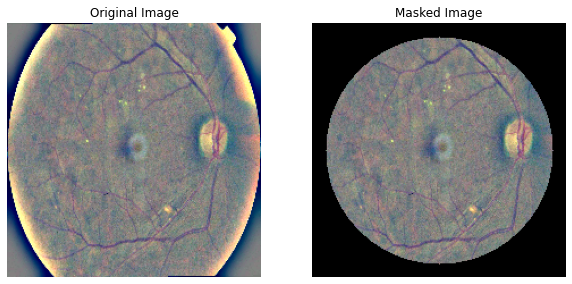

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_circle_mask(img, scale=0.9):
    """
    Applies a circular mask to the image to keep the center part and fade the edges.

    Parameters:
    - img: The input image in RGB format.
    - scale: Determines the radius of the circle as a fraction of the image size.

    Returns:
    - The masked image.
    """
    height, width = img.shape[:2]
    center = (width // 2, height // 2)
    radius = int(min(center) * scale)
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.circle(mask, center, radius, (255, 255, 255), thickness=-1)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

# Example usage
image_path = 'preprocessed_images/2019_agument_total/augmented_5_5777ef74c9ec.png'  # Replace this with the path to your image file
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
masked_img = apply_circle_mask(img, scale=0.9)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_img)
plt.title('Masked Image')
plt.axis('off')

plt.show()

# Optionally, save the result
# output_path = 'path_to_save_masked_image.jpg'  # Specify the output path
# cv2.imwrite(output_path, cv2.cvtColor(masked_img, cv2.COLOR_RGB2BGR))


In [5]:
import os
def preprocess_and_apply_mask(input_dir, output_dir, scale=0.9):
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                masked_img = apply_circle_mask(img, scale)
                
                # Prepare the output directory and file path
                output_subdir = root.replace(input_dir, output_dir)
                if not os.path.exists(output_subdir):
                    os.makedirs(output_subdir)
                output_image_path = os.path.join(output_subdir, file)
                
                # Save the masked image
                cv2.imwrite(output_image_path, cv2.cvtColor(masked_img, cv2.COLOR_RGB2BGR))  # Convert RGB back to BGR for saving

# Example call
input_dir = 'preprocessed_images/2019_agument_total'  # The directory containing the images to process
output_dir = 'preprocessed_images/2019_agument_total_qubian'  # The directory to save the processed images
preprocess_and_apply_mask(input_dir, output_dir)


In [4]:
%pip install opencv-python

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


# 合并图片

In [5]:
import os
import shutil

def merge_folders(folder1, folder2, output_folder):
    # 遍历第一个文件夹中的所有子文件夹
    for subdir, dirs, files in os.walk(folder1):
        for dir_name in dirs:
            subdir_path = os.path.join(subdir, dir_name)
            output_subdir = os.path.join(output_folder, dir_name)
            
            # 创建输出目录的相应子文件夹
            if not os.path.exists(output_subdir):
                os.makedirs(output_subdir)
            
            # 复制第一个文件夹中的图片
            for file in os.listdir(subdir_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    src_file_path = os.path.join(subdir_path, file)
                    dst_file_path = os.path.join(output_subdir, file)
                    shutil.copy2(src_file_path, dst_file_path)
            
            # 检查第二个文件夹中相同的子文件夹并复制图片
            subdir_path_2 = os.path.join(folder2, dir_name)
            if os.path.exists(subdir_path_2):
                for file in os.listdir(subdir_path_2):
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        src_file_path = os.path.join(subdir_path_2, file)
                        dst_file_path = os.path.join(output_subdir, file)
                        shutil.copy2(src_file_path, dst_file_path)

# 设置文件夹路径
folder1 = 'preprocessed_images/test'
folder2 = 'preprocessed_images/train'
output_folder = 'preprocessed_images/total'

# 调用函数
merge_folders(folder1, folder2, output_folder)


# 修改图片后缀名

In [11]:
import os
from PIL import Image

def convert_jpeg_to_png(directory):
    """
    将指定目录下的所有.jpeg文件转换为.png格式。
    :param directory: 包含.jpeg文件的目录路径。
    """
    for filename in os.listdir(directory):
        if filename.endswith(".jpeg"):
            # 构建完整的文件路径
            filepath = os.path.join(directory, filename)
            # 加载图像
            img = Image.open(filepath)
            # 构建新的文件名（替换扩展名）
            new_filepath = os.path.join(directory, filename[:-5] + ".png")
            # 保存图像为PNG格式
            img.save(new_filepath, "PNG")
            print(f"Converted {filename} to PNG format.")
            # 可选：如果你想删除原始的.jpeg文件，取消注释下面的行
            os.remove(filepath)
            print(f"Deleted original {filename}.")

# 替换为你的目录路径
directory_path = "preprocessed_images/2015&2019_total"
convert_jpeg_to_png(directory_path)


Converted 24954_left.jpeg to PNG format.
Deleted original 24954_left.jpeg.
Converted 37795_right.jpeg to PNG format.
Deleted original 37795_right.jpeg.
Converted 41294_right.jpeg to PNG format.
Deleted original 41294_right.jpeg.
Converted 33312_left.jpeg to PNG format.
Deleted original 33312_left.jpeg.
Converted 11492_left.jpeg to PNG format.
Deleted original 11492_left.jpeg.
Converted 12246_right.jpeg to PNG format.
Deleted original 12246_right.jpeg.
Converted 12478_left.jpeg to PNG format.
Deleted original 12478_left.jpeg.
Converted 22652_right.jpeg to PNG format.
Deleted original 22652_right.jpeg.
Converted 20120_right.jpeg to PNG format.
Deleted original 20120_right.jpeg.
Converted 12040_right.jpeg to PNG format.
Deleted original 12040_right.jpeg.
Converted 17407_left.jpeg to PNG format.
Deleted original 17407_left.jpeg.
Converted 24580_right.jpeg to PNG format.
Deleted original 24580_right.jpeg.
Converted 10879_left.jpeg to PNG format.
Deleted original 10879_left.jpeg.
Converted 3

# 合并文件夹图片

In [9]:
import shutil
import os
from pathlib import Path

# Assuming 'folder1' and 'folder2' are the names of the source folders
# and 'new_folder' is the name of the destination folder.
# These folders are located at '/mnt/data/'

folder1_path = 'preprocessed_images/total_noclassical'
folder2_path = 'preprocessed_images/2015_total'
new_folder_path = 'preprocessed_images/2015&2019_total'

# Create a new folder if it does not exist
Path(new_folder_path).mkdir(parents=True, exist_ok=True)

# Function to copy all files from a given source directory to a target directory
def copy_files_to_new_folder(source_folder, target_folder):
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)
        if os.path.isfile(file_path):
            shutil.copy(file_path, target_folder)

# Copy files from both folders to the new folder
copy_files_to_new_folder(folder1_path, new_folder_path)
copy_files_to_new_folder(folder2_path, new_folder_path)

# If you want to list the files in the new folder to confirm the copy
files_in_new_folder = os.listdir(new_folder_path)
files_in_new_folder


['augmented_6_5e7db41b3bee.png',
 'augmented_2_b90bc89ce8d8.png',
 'augmented_6_a32b5ce3d48a.png',
 'augmented_6_613028ede6a0.png',
 'augmented_2_905cc86bf100.png',
 'augmented_3_79d44db3da2d.png',
 'augmented_5_02685f13cefd.png',
 'augmented_3_64bad93fde3f.png',
 'augmented_3_262ad704319c.png',
 'augmented_4_3796af4d987a.png',
 'augmented_2_df4913ca3712.png',
 'augmented_4_3b232b394e4f.png',
 'augmented_6_63b4d030b016.png',
 'augmented_2_bfdee9be1f1d.png',
 'augmented_3_f1dc26c4bfa3.png',
 'augmented_1_60f15dd68d30.png',
 'augmented_4_bba38f2294a3.png',
 'augmented_4_8ae049175db6.png',
 'augmented_3_df84e7113003.png',
 'augmented_3_d271d3a2b552.png',
 'augmented_5_fdd534271f3d.png',
 'augmented_6_ff8a0b45c789.png',
 'augmented_4_0ada12c0e78f.png',
 'augmented_4_e821c1b6417a.png',
 'augmented_5_95e732e043a1.png',
 'augmented_1_d271d3a2b552.png',
 'augmented_5_c6a145742708.png',
 'augmented_4_5b5b80a3edee.png',
 'augmented_3_7270367410a1.png',
 'augmented_1_70d657f8f503.png',
 'augmente

# 数据增强
详情见jyptroom

In [11]:
import os
import random
from PIL import Image, ImageOps
from torchvision import transforms

# 定义一个函数来随机应用组合增强
def apply_random_transforms(image):
    # 定义可能的转换
    transformations = [
        lambda x: x,  # 无变化
        transforms.ColorJitter(brightness=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
#         ImageOps.equalize
    ]

    # 随机选择转换的数量和转换
    num_transforms_to_apply = random.randint(1, len(transformations))
    selected_transforms = random.sample(transformations, num_transforms_to_apply)

    # 应用选定的转换
    for transform in selected_transforms:
        image = transform(image)
    return image

# 文件夹路径
folder_path = 'input/train_images/4/'  # 替换为你的文件夹路径
save_folder_path = 'input/train_images/4/'  # 保存处理后图像的路径

# 确保保存目录存在
os.makedirs(save_folder_path, exist_ok=True)

# 打印文件夹中的文件总数
print("总文件数:", len(os.listdir(folder_path)))

# 设置计数器和目标处理图片数量
processed_images = 0
target_images = random.randint(200, 400)

# 处理图片并捕获可能的错误
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)

            for i in range(9, 10):
                augmented_image = apply_random_transforms(image)
                augmented_image_path = os.path.join(save_folder_path, f"augmented_{i}_{filename}")
                augmented_image.save(augmented_image_path)
                
                # 更新计数器
                processed_images += 1
                
                # 检查是否达到目标数量
                if processed_images >= target_images:
                    break

        except Exception as e:
            print(f"处理文件 {filename} 时出错: {e}")
            continue  # 如果出错，跳过当前图像，继续处理下一个图像
    
    # 检查是否达到目标数量
    if processed_images >= target_images:
        break

# 打印处理完成的消息
print("处理完成")


总文件数: 1559
处理文件 augmented_1_cd54d022e37d.png 时出错: image file is truncated
处理完成


# 批量改尺寸

In [2]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    return im

# 图片源文件夹和目标文件夹路径
image_folder = 'preprocessed_images/2019_agument_total/'
save_folder = 'preprocessed_images/2019_agument_total'

# 如果目标文件夹不存在，则创建它
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# 获取图片文件夹内所有图片的名称
image_files = os.listdir(image_folder)
N = len(image_files)

# 遍历图片，进行预处理并保存
for i, image_file in enumerate(tqdm(image_files)):
    image_path = os.path.join(image_folder, image_file)
    processed_image = preprocess_image(image_path)
    
    # 保存处理后的图片到新文件夹
    save_path = os.path.join(save_folder, image_file)
    processed_image.save(save_path)


100%|██████████| 6007/6007 [02:49<00:00, 35.37it/s]


# 标签数量统计

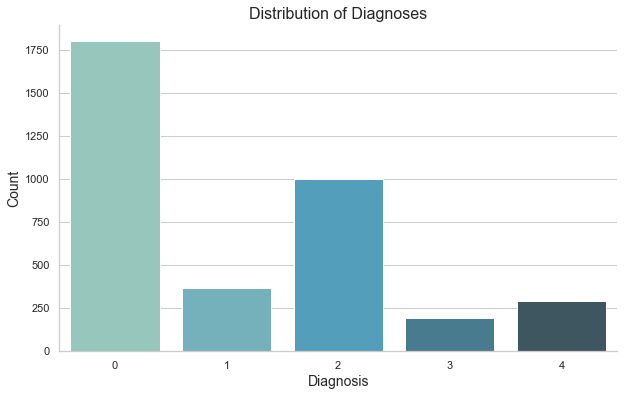

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 假设你的CSV文件路径是'path_to_your_file.csv'
file_path = 'data/train.csv'

# 使用Pandas读取CSV文件
data = pd.read_csv(file_path)

# 统计每个标签的数量
label_counts = data['diagnosis'].value_counts()
# 设置图表风格
sns.set(style="whitegrid")

# 创建图表
plt.figure(figsize=(10, 6))  # 调整图表大小

# 绘制直方图，使用GnBu_d调色板
sns.barplot(x=label_counts.index, y=label_counts.values, palette="GnBu_d")

# 设置标签和标题
plt.xlabel('Diagnosis', fontsize=14)  # x轴标签
plt.ylabel('Count', fontsize=14)  # y轴标签
plt.title('Distribution of Diagnoses', fontsize=16)  # 标题

# 移除不必要的轴线
sns.despine()

# 保存图像至文件，提高分辨率
plt.savefig('raw_diagnoses.png', dpi=300)

# 展示图表
plt.show()

# 关闭图表，避免在内存中占用太多资源
plt.close()

# 打印统计表格
print(label_counts)

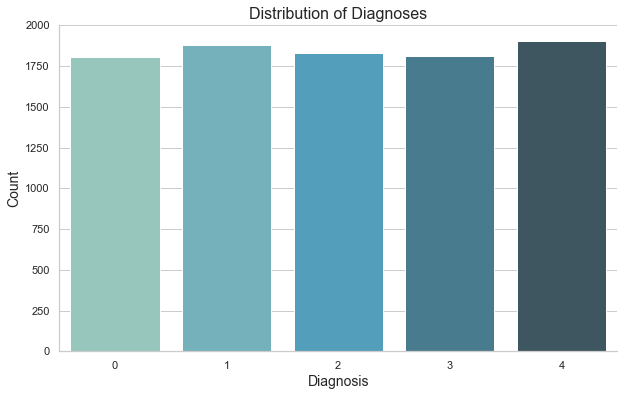

4    1906
1    1879
2    1833
3    1811
0    1805
Name: diagnosis, dtype: int64


In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 假设你的CSV文件路径是'path_to_your_file.csv'
file_path = '2019_agument.csv'

# 使用Pandas读取CSV文件
data = pd.read_csv(file_path)

# 统计每个标签的数量
label_counts = data['diagnosis'].value_counts()
# 设置图表风格
sns.set(style="whitegrid")

# 创建图表
plt.figure(figsize=(10, 6))  # 调整图表大小

# 绘制直方图，使用GnBu_d调色板
sns.barplot(x=label_counts.index, y=label_counts.values, palette="GnBu_d")

# 设置标签和标题
plt.xlabel('Diagnosis', fontsize=14)  # x轴标签
plt.ylabel('Count', fontsize=14)  # y轴标签
plt.title('Distribution of Diagnoses', fontsize=16)  # 标题

# 移除不必要的轴线
sns.despine()

# 保存图像至文件，提高分辨率
plt.savefig('distribution_of_diagnoses.png', dpi=300)

# 展示图表
plt.show()

# 关闭图表，避免在内存中占用太多资源
plt.close()

# 打印统计表格
print(label_counts)
